# Instructions

You can run each code snippet in order and you end up with a trained model and a nice little graph of some important performance metrics.

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np

from data import get_data
from models import TCN

from sklearn.model_selection import train_test_split
import argparse

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

import statistics as stat

In [2]:
torch.set_printoptions(threshold=5000)

class args():
    def __init__(self):
        self.regularization=1
        self.lamda1=0.075
        self.lamda2=0.00075
        self.current_event=5
        self.channel_size=32
        self.kernel_size=5
        self.num_epochs=50
        self.batch_size=32
        self.learning_rate=1e-3
        self.warm_up=1
        self.warm_up_epoch=5
        self.multi_pattern=0
        self.course='2'
        self.mode='train'

args = args()


In [3]:
train_x, train_y, test_x, test_y = get_data()

train_num = len(train_x)
test_num = len(test_x)
print('Data Loaded Complete')
print('==========================================================')

Data Loaded Complete


In [4]:
class ClipDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
                
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        clip = torch.Tensor(self.x[idx])
        if self.y[idx] == 0:
            label = torch.Tensor([1,0])
        else:
            label = torch.Tensor([0,1])
        return clip, label

In [5]:
train_dataset = ClipDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)

test_dataset = ClipDataset(test_x, test_y)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=True)

In [15]:
def train(ep, lambda1, lambda2, args):
    training_loss = []
    training_reg_loss = []
    total_training_loss = []
    global batch_size, iters, epochs
    print('Epoch: {}'.format(ep))
    model.train()
    for param in model.parameters():
        param.requires_grad = True
    optimizer.zero_grad()
    progress = tqdm.tqdm(total=train_num/32, ncols=75, desc='Train {}'.format(ep))
    loop_train = tqdm.tqdm(train_loader, total=len(train_loader), leave=True)
    for idx, (clips, labels) in enumerate(loop_train):
        predict = model.forward(clips)
        loss = criterion(predict.squeeze(), labels)
        training_loss.append(float(loss.detach().numpy()))
        regularization = 0
        r_s, L1 = model.regularization_uni()
        regularization = lambda1 * r_s + lambda2 * L1
        training_reg_loss.append(float(regularization.detach().numpy()))
        loss = loss + regularization
        total_training_loss.append(float(loss.detach().numpy()))
        loss.backward()
        progress.update(1)
        optimizer.step()
        optimizer.zero_grad()
    progress.close()
    return training_loss, training_reg_loss, total_training_loss, predict


def evaluate():
    model.eval()
    testing_loss = []
    testing_reg_loss = []
    total_testing_loss = []
    #kappa_info = [both_gaming, both_non, pred_gaming_true_non, pred_non_true_gaming]
    kappa_info = [0,0,0,0,0]
    count_info = [0,0]
    progress = tqdm.tqdm(total=test_num/32, ncols=75, desc='Test {}'.format(ep))
    loop_test = tqdm.tqdm(test_loader, total=len(test_loader), leave=True)
    for idx, (clips, labels) in enumerate(loop_test):
        progress.update(1)
        predict = model(clips)
        loss = criterion(predict.squeeze(), labels)
        kappa_info = list( np.array(kappa_info) + np.array(num_right_every_way(predict.squeeze(), labels)))
        count_info = list( np.array(count_info) + np.array(num_right_each(predict.squeeze(), labels)))
        testing_loss.append(float(loss.detach().numpy()))

    progress.close()
    kappa = get_kappa(kappa_info)
    return testing_loss, testing_reg_loss, total_testing_loss, predict, kappa, count_info

def num_right(predict, labels):
    """num_right takes in the array of predictions and the array of true labels 
    and returns the total number of correct predictions"""
    count = 0
    for indx, pred in enumerate(predict.detach().numpy()):
        if max_label(pred) == max_label(labels.detach().numpy()[indx]):
            count += 1
    return count

def num_right_each(predict, labels):
    """num_right_each takes in the array of predictions and the array of true labels 
    and returns the number of correct predictions individually for each label"""
    count_gaming = 0
    count_non = 0
    for indx, pred in enumerate(predict.detach().numpy()):
        if max_label(pred) == max_label(labels.detach().numpy()[indx]):
            if max_label(pred) == 0:
                count_non += 1
            else:
                count_gaming += 1
    return [count_gaming, count_non]

def num_right_every_way(predict, labels):
    """num_right_every_way takes in the array of predictions and the array of true labels and returns
    the true positive, true negative, false positive, false negative numbers, and the number of predictions"""
    both_gaming, both_non, pred_gaming_true_non, pred_non_true_gaming = 0,0,0,0
    for indx, pred in enumerate(predict.detach().numpy()):
        if max_label(pred) == max_label(labels.detach().numpy()[indx]):
            if max_label(pred) == 0:
                both_non += 1
            else:
                both_gaming += 1
        else:
            if max_label(pred) == 0:
                pred_non_true_gaming += 1
            else:
                pred_gaming_true_non += 1
    return [both_gaming, both_non, pred_gaming_true_non, pred_non_true_gaming, len(labels)]

def max_label(label):
    """helper function that given a confidence value for [no,yes] will return the value associated with the max"""
    [no, yes] = label
    if yes > no:
        return 1
    else:
        return 0
    
def get_kappa(kappa_info):
    """get_kappa calculates the kappa for one epoch given all of the kappa info"""
    [both_gaming, both_non, pred_gaming_true_non, pred_non_true_gaming, total] = kappa_info
    po = (both_gaming+both_non)/total
    pgaming = ((both_gaming+pred_gaming_true_non)/total) * ((both_gaming+pred_non_true_gaming)/total)
    pnon = ((both_non+pred_non_true_gaming)/total) * ((both_non+pred_gaming_true_non)/total)
    pe = pgaming+pnon
    return (po - pe)/(1 - pe)

def generate_inner_plots(training_loss, training_reg_loss, total_training_loss):
    fig, axs = plt.subplots(3,1)
    #loss
    num = []
    ave_loss = []
    for i in range(0, 20):
        total = 0
        for j in range(0,5):
            total += training_loss[i+j]
        ave_loss.append(total/10)
        num.append(i*10)
    axs[0].plot(num, ave_loss)
    axs[0].set_ylim(0, .5)
    #regularization
    axs[1].plot(range(0,len(training_reg_loss)), training_reg_loss)
    axs[1].set_ylim(0, .5)
    #total
    ave_total_loss = []
    for i in range(0, 20):
        total = 0
        for j in range(0,5):
            total += training_loss[i+j]
        ave_total_loss.append(total/10)
    axs[2].plot(num, ave_total_loss)
    axs[2].set_ylim(0, .5)
    print("ave loss: {}".format(ave_loss[-1]))
    print("last reg: {}".format(training_reg_loss[-1]))
    print("ave total loss: {}".format(ave_total_loss[-1]))

def generate_plots(loss_list, kappa_list, count_right_gaming_list, count_right_non_list, count_list):
    fig, axs = plt.subplots(2, 2)
    #ave % correct non gaming
    ave_count_right_non_list = []
    num = []
    for i in range(0,10):
        total = 0
        for j in range(0,5):
            total += count_right_non_list[i+j]
        ave_count_right_non_list.append(total/5)
        num.append(i*5)
    percentages0 = []
    for i in ave_count_right_non_list:
        percentages0.append(i/2035)
    axs[0, 0].plot(num, percentages0)  
    axs[0, 0].set_xlabel("Epoch number")
    axs[0, 0].set_ylabel("% correct non gaming") 
    axs[0, 0].set_ylim(.85, 1)
    axs[0, 0].set_title("Average % correct non gaming")
    
    #Loss graph
#     axs[0, 0].plot(range(0,len(loss_list)), loss_list)
#     axs[0, 0].set_xlabel("Epoch number")
#     axs[0, 0].set_ylabel("Loss")
#     axs[0, 0].set_ylim(0, 1)
#     axs[0, 0].set_title("Loss")

    #kappa
    percentages1 = []
    for i in count_list:
        percentages1.append(i/2170)
    ave_performance = []
    for i in range(0,10):
        total = 0
        for j in range(0,5):
            total += percentages1[i+j]
        ave_performance.append(total/5)
    axs[1, 0].plot(num, ave_performance)  
    axs[1, 0].set_xlabel("Epoch number")
    axs[1, 0].set_ylabel("Accuracy") 
    axs[1, 0].set_ylim(.93, 1)
    axs[1, 0].set_title("Average accuracy")
    
    #ave % correct gaming
    ave_count_right_gaming_list = []
    for i in range(0,10):
        total = 0
        for j in range(0,5):
            total += count_right_gaming_list[i+j]
        ave_count_right_gaming_list.append(total/5)
    percentages2 = []
    for i in ave_count_right_gaming_list:
        percentages2.append(i/135)
    axs[0, 1].plot(num, percentages2)  
    axs[0, 1].set_xlabel("Epoch number")
    axs[0, 1].set_ylabel("% correct gaming") 
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].set_title("Average % correct gaming")
    
    #average kappa
    ave_kappa = []
    for i in range(0,10):
        total = 0
        for j in range(0,5):
            total += kappa_list[i+j]
        ave_kappa.append(total/5)
    axs[1, 1].set_xlabel("Epoch number")
    axs[1, 1].set_ylabel("Kappa")
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].plot(range(0,len(ave_kappa)), ave_kappa)
    axs[1, 1].set_title("average kappa")
    
    #printing stuff
#     print("ave loss: {}".format(sum(loss_list[-5:]) / len(loss_list[-5:])))
    print("ave kappa: {}".format(ave_kappa[-1]))
    print("ave % correct gaming: {}".format(percentages2[-1]))
    print("ave % correct non gaming: {}".format(percentages0[-1]))
    print("ave accuracy: {}".format(percentages1[-1]))
    
    
#     fig.tight_layout()

In [9]:
c_event = args.current_event
f_event = 1
batch_size = args.batch_size
file_name = "TextReplay"

# model configuration

if args.mode == 'train':
    channel_sizes = args.channel_size
    kernel_size = args.kernel_size
    epochs = args.num_epochs
    hidden_size = 40
    length = 24
    if args.multi_pattern:
        length = 14
    linear_size = channel_sizes * (c_event - kernel_size + 1)
    model = TCN(length, channel_sizes, f_event, kernel_size, hidden_size, linear_size)
    lr = args.learning_rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()


# experiment

if args.mode == 'train':
    best = 1000
#     count_list = []
    loss_list = []
    kappa_list = []
    count_right_gaming_list = []
    count_right_non_list = []
    testing_loss = []
    testing_reg_loss = []
    total_testing_loss = []
    training_loss = []
    training_reg_loss = []
    total_training_loss = []
    for ep in range(args.num_epochs):
        # cond is used when you want to graph the loss within an epoch, it stops the training where you want to look
#         cond = False
        if args.warm_up:
            if ep < args.warm_up_epoch:
                training_loss, training_reg_loss, total_training_loss, predict_train = train(ep, 0, 0, args)
            elif ep < args.warm_up_epoch + 10 and ep >= args.warm_up_epoch:
                l1 = (ep - args.warm_up_epoch) * args.lamda1 / 10
                l2 = (ep - args.warm_up_epoch) * args.lamda2 / 10
                training_loss, training_reg_loss, total_training_loss, predict_train = train(ep, l1, l2, args)
            else:
                training_loss, training_reg_loss, total_training_loss, predict_train = train(ep, args.lamda1, args.lamda2, args)
#                 cond = True
        else:
            training_loss, training_reg_loss, total_training_loss, predict_train = train(ep, args.lamda1, args.lamda2, args)

        testing_loss, testing_reg_loss, total_testing_loss, predict_loss, kappa, [count_gaming, count_non] = evaluate()
        loss_list.append(stat.mean(testing_loss))
        kappa_list.append(kappa)
        count_right_gaming_list.append(count_gaming)
        count_right_non_list.append(count_non)
#         if cond:
#             break
        


    torch.save(model, 'model/model_' + args.course + '_' + file_name + '.pt')

model = torch.load('model/model_' + args.course + '_' + file_name +'.pt')
count_list = list(np.array(count_right_gaming_list) + np.array(count_right_non_list))



Epoch: 0


Train 0:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 0:  15%|███▏                  | 30/205.0625 [00:00<00:00, 294.21it/s]
Train 0:  30%|██████▌               | 61/205.0625 [00:00<00:00, 301.41it/s]
Train 0:  45%|█████████▊            | 92/205.0625 [00:00<00:00, 303.71it/s]
Train 0:  60%|████████████▌        | 123/205.0625 [00:00<00:00, 304.71it/s]
Train 0:  75%|███████████████▊     | 154/205.0625 [00:00<00:00, 305.26it/s]
Train 0:  91%|███████████████████  | 186/205.0625 [00:00<00:00, 307.37it/s]
100%|██████████| 206/206 [00:00<00:00, 305.07it/s]
Train 0: 206it [00:00, 303.52it/s]                                         
Test 0:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 0:  65%|███████████████▌        | 44/67.8125 [00:00<00:00, 436.34it/s]
100%|██████████| 68/68 [00:00<00:00, 438.02it/s]
Test 0: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 428.59it/s]


Epoch: 1


Train 1:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 1:  16%|███▌                  | 33/205.0625 [00:00<00:00, 320.64it/s]
Train 1:  32%|███████               | 66/205.0625 [00:00<00:00, 308.94it/s]
Train 1:  47%|██████████▍           | 97/205.0625 [00:00<00:00, 304.28it/s]
Train 1:  62%|█████████████        | 128/205.0625 [00:00<00:00, 302.24it/s]
Train 1:  78%|████████████████▎    | 159/205.0625 [00:00<00:00, 300.36it/s]
Train 1:  93%|███████████████████▌ | 191/205.0625 [00:00<00:00, 304.71it/s]
100%|██████████| 206/206 [00:00<00:00, 306.21it/s]
Train 1: 206it [00:00, 304.37it/s]                                         
Test 1:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 1:  68%|████████████████▎       | 46/67.8125 [00:00<00:00, 451.75it/s]
100%|██████████| 68/68 [00:00<00:00, 437.78it/s]
Test 1: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 428.82it/s]


Epoch: 2


Train 2:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 2:  16%|███▍                  | 32/205.0625 [00:00<00:00, 315.97it/s]
Train 2:  31%|██████▊               | 64/205.0625 [00:00<00:00, 313.17it/s]
Train 2:  47%|██████████▎           | 96/205.0625 [00:00<00:00, 307.28it/s]
Train 2:  62%|█████████████        | 127/205.0625 [00:00<00:00, 306.58it/s]
Train 2:  77%|████████████████▏    | 158/205.0625 [00:00<00:00, 301.54it/s]
Train 2:  92%|███████████████████▎ | 189/205.0625 [00:00<00:00, 304.33it/s]
100%|██████████| 206/206 [00:00<00:00, 307.21it/s]
Train 2: 206it [00:00, 305.39it/s]                                         
Test 2:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 2:  68%|████████████████▎       | 46/67.8125 [00:00<00:00, 456.79it/s]
100%|██████████| 68/68 [00:00<00:00, 445.97it/s]
Test 2: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 435.39it/s]


Epoch: 3


Train 3:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 3:  15%|███▎                  | 31/205.0625 [00:00<00:00, 307.54it/s]
Train 3:  30%|██████▋               | 62/205.0625 [00:00<00:00, 301.77it/s]
Train 3:  46%|██████████            | 94/205.0625 [00:00<00:00, 306.89it/s]
Train 3:  61%|████████████▉        | 126/205.0625 [00:00<00:00, 308.78it/s]
Train 3:  77%|████████████████     | 157/205.0625 [00:00<00:00, 305.95it/s]
Train 3:  92%|███████████████████▎ | 188/205.0625 [00:00<00:00, 304.50it/s]
100%|██████████| 206/206 [00:00<00:00, 305.51it/s]
Train 3: 206it [00:00, 303.91it/s]                                         
Test 3:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 3:  66%|███████████████▉        | 45/67.8125 [00:00<00:00, 439.05it/s]
100%|██████████| 68/68 [00:00<00:00, 425.85it/s]
Test 3: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 416.43it/s]


Epoch: 4


Train 4:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 4:  16%|███▍                  | 32/205.0625 [00:00<00:00, 313.01it/s]
Train 4:  31%|██████▊               | 64/205.0625 [00:00<00:00, 308.32it/s]
Train 4:  47%|██████████▎           | 96/205.0625 [00:00<00:00, 312.28it/s]
Train 4:  62%|█████████████        | 128/205.0625 [00:00<00:00, 308.77it/s]
Train 4:  78%|████████████████▎    | 159/205.0625 [00:00<00:00, 306.88it/s]
Train 4:  93%|███████████████████▍ | 190/205.0625 [00:00<00:00, 305.88it/s]
100%|██████████| 206/206 [00:00<00:00, 308.21it/s]
Train 4: 206it [00:00, 306.14it/s]                                         
Test 4:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 4:  63%|███████████████▏        | 43/67.8125 [00:00<00:00, 422.39it/s]
100%|██████████| 68/68 [00:00<00:00, 420.65it/s]
Test 4: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 411.07it/s]


Epoch: 5


Train 5:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 5:  15%|███▎                  | 31/205.0625 [00:00<00:00, 305.01it/s]
Train 5:  30%|██████▋               | 62/205.0625 [00:00<00:00, 303.76it/s]
Train 5:  45%|█████████▉            | 93/205.0625 [00:00<00:00, 304.17it/s]
Train 5:  60%|████████████▋        | 124/205.0625 [00:00<00:00, 304.64it/s]
Train 5:  76%|███████████████▉     | 156/205.0625 [00:00<00:00, 308.62it/s]
Train 5:  91%|███████████████████▏ | 187/205.0625 [00:00<00:00, 304.87it/s]
100%|██████████| 206/206 [00:00<00:00, 304.69it/s]
Train 5: 206it [00:00, 302.88it/s]                                         
Test 5:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 5:  63%|███████████████▏        | 43/67.8125 [00:00<00:00, 427.89it/s]
100%|██████████| 68/68 [00:00<00:00, 427.01it/s]
Test 5: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 417.71it/s]


Epoch: 6


Train 6:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 6:  15%|███▎                  | 31/205.0625 [00:00<00:00, 305.21it/s]
Train 6:  30%|██████▋               | 62/205.0625 [00:00<00:00, 302.09it/s]
Train 6:  46%|██████████            | 94/205.0625 [00:00<00:00, 307.17it/s]
Train 6:  61%|████████████▊        | 125/205.0625 [00:00<00:00, 307.70it/s]
Train 6:  76%|███████████████▉     | 156/205.0625 [00:00<00:00, 308.22it/s]
Train 6:  91%|███████████████████▏ | 187/205.0625 [00:00<00:00, 307.02it/s]
100%|██████████| 206/206 [00:00<00:00, 307.90it/s]
Train 6: 206it [00:00, 306.04it/s]                                         
Test 6:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 6:  66%|███████████████▉        | 45/67.8125 [00:00<00:00, 442.04it/s]
100%|██████████| 68/68 [00:00<00:00, 440.22it/s]
Test 6: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 429.71it/s]


Epoch: 7


Train 7:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 7:  15%|███▎                  | 31/205.0625 [00:00<00:00, 307.86it/s]
Train 7:  30%|██████▋               | 62/205.0625 [00:00<00:00, 302.62it/s]
Train 7:  46%|██████████            | 94/205.0625 [00:00<00:00, 306.70it/s]
Train 7:  61%|████████████▊        | 125/205.0625 [00:00<00:00, 306.31it/s]
Train 7:  76%|███████████████▉     | 156/205.0625 [00:00<00:00, 305.28it/s]
Train 7:  92%|███████████████████▎ | 188/205.0625 [00:00<00:00, 308.11it/s]
100%|██████████| 206/206 [00:00<00:00, 307.80it/s]
Train 7: 206it [00:00, 305.99it/s]                                         
Test 7:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 7:  65%|███████████████▌        | 44/67.8125 [00:00<00:00, 434.11it/s]
100%|██████████| 68/68 [00:00<00:00, 430.32it/s]
Test 7: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 421.01it/s]


Epoch: 8


Train 8:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 8:  15%|███▎                  | 31/205.0625 [00:00<00:00, 305.25it/s]
Train 8:  31%|██████▊               | 63/205.0625 [00:00<00:00, 310.13it/s]
Train 8:  47%|██████████▎           | 96/205.0625 [00:00<00:00, 317.97it/s]
Train 8:  63%|█████████████▏       | 129/205.0625 [00:00<00:00, 318.60it/s]
Train 8:  79%|████████████████▌    | 162/205.0625 [00:00<00:00, 319.29it/s]
Train 8:  95%|███████████████████▊ | 194/205.0625 [00:00<00:00, 318.68it/s]
100%|██████████| 206/206 [00:00<00:00, 317.18it/s]
Train 8: 206it [00:00, 315.37it/s]                                         
Test 8:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 8:  68%|████████████████▎       | 46/67.8125 [00:00<00:00, 454.12it/s]
100%|██████████| 68/68 [00:00<00:00, 446.16it/s]
Test 8: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 437.06it/s]


Epoch: 9


Train 9:   0%|                                | 0/205.0625 [00:00<?, ?it/s]
Train 9:  16%|███▌                  | 33/205.0625 [00:00<00:00, 326.20it/s]
Train 9:  32%|███████               | 66/205.0625 [00:00<00:00, 317.88it/s]
Train 9:  48%|██████████▌           | 98/205.0625 [00:00<00:00, 318.67it/s]
Train 9:  64%|█████████████▍       | 131/205.0625 [00:00<00:00, 320.59it/s]
Train 9:  80%|████████████████▊    | 164/205.0625 [00:00<00:00, 316.30it/s]
Train 9:  96%|████████████████████ | 196/205.0625 [00:00<00:00, 317.18it/s]
100%|██████████| 206/206 [00:00<00:00, 318.29it/s]
Train 9: 206it [00:00, 316.47it/s]                                         
Test 9:   0%|                                  | 0/67.8125 [00:00<?, ?it/s]
Test 9:  65%|███████████████▌        | 44/67.8125 [00:00<00:00, 438.80it/s]
100%|██████████| 68/68 [00:00<00:00, 431.80it/s]
Test 9: 100%|████████████████████████| 68/67.8125 [00:00<00:00, 422.65it/s]


Epoch: 10


Train 10:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 10:  16%|███▍                 | 33/205.0625 [00:00<00:00, 323.96it/s]
Train 10:  32%|██████▊              | 66/205.0625 [00:00<00:00, 321.44it/s]
Train 10:  48%|██████████▏          | 99/205.0625 [00:00<00:00, 324.21it/s]
Train 10:  64%|████████████▊       | 132/205.0625 [00:00<00:00, 321.79it/s]
Train 10:  80%|████████████████    | 165/205.0625 [00:00<00:00, 318.29it/s]
Train 10:  97%|███████████████████▎| 198/205.0625 [00:00<00:00, 319.43it/s]
100%|██████████| 206/206 [00:00<00:00, 320.12it/s]
Train 10: 206it [00:00, 318.45it/s]                                        
Test 10:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 10:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 435.96it/s]
100%|██████████| 68/68 [00:00<00:00, 446.33it/s]
Test 10: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 437.14it/s]


Epoch: 11


Train 11:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 11:  15%|███▏                 | 31/205.0625 [00:00<00:00, 308.17it/s]
Train 11:  30%|██████▎              | 62/205.0625 [00:00<00:00, 308.97it/s]
Train 11:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 309.41it/s]
Train 11:  61%|████████████▏       | 125/205.0625 [00:00<00:00, 312.81it/s]
Train 11:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 311.65it/s]
Train 11:  93%|██████████████████▌ | 190/205.0625 [00:00<00:00, 315.62it/s]
100%|██████████| 206/206 [00:00<00:00, 314.96it/s]
Train 11: 206it [00:00, 313.13it/s]                                        
Test 11:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 11:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 446.64it/s]
100%|██████████| 68/68 [00:00<00:00, 439.58it/s]
Test 11: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 430.76it/s]


Epoch: 12


Train 12:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 12:  16%|███▍                 | 33/205.0625 [00:00<00:00, 320.80it/s]
Train 12:  32%|██████▊              | 66/205.0625 [00:00<00:00, 325.85it/s]
Train 12:  48%|██████████▏          | 99/205.0625 [00:00<00:00, 322.18it/s]
Train 12:  64%|████████████▊       | 132/205.0625 [00:00<00:00, 317.49it/s]
Train 12:  80%|███████████████▉    | 164/205.0625 [00:00<00:00, 317.37it/s]
Train 12:  96%|███████████████████ | 196/205.0625 [00:00<00:00, 317.37it/s]
100%|██████████| 206/206 [00:00<00:00, 318.80it/s]
Train 12: 206it [00:00, 316.99it/s]                                        
Test 12:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 12:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 444.33it/s]
100%|██████████| 68/68 [00:00<00:00, 446.27it/s]
Test 12: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 437.05it/s]


Epoch: 13


Train 13:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 13:  15%|███▏                 | 31/205.0625 [00:00<00:00, 306.90it/s]
Train 13:  31%|██████▌              | 64/205.0625 [00:00<00:00, 318.55it/s]
Train 13:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 317.07it/s]
Train 13:  62%|████████████▍       | 128/205.0625 [00:00<00:00, 316.12it/s]
Train 13:  78%|███████████████▌    | 160/205.0625 [00:00<00:00, 314.63it/s]
Train 13:  94%|██████████████████▋ | 192/205.0625 [00:00<00:00, 314.08it/s]
100%|██████████| 206/206 [00:00<00:00, 315.19it/s]
Train 13: 206it [00:00, 313.29it/s]                                        
Test 13:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 13:  68%|███████████████▌       | 46/67.8125 [00:00<00:00, 458.19it/s]
100%|██████████| 68/68 [00:00<00:00, 449.05it/s]
Test 13: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 439.75it/s]


Epoch: 14


Train 14:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 14:  15%|███▏                 | 31/205.0625 [00:00<00:00, 309.81it/s]
Train 14:  31%|██████▍              | 63/205.0625 [00:00<00:00, 315.43it/s]
Train 14:  46%|█████████▋           | 95/205.0625 [00:00<00:00, 314.89it/s]
Train 14:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 312.14it/s]
Train 14:  78%|███████████████▌    | 159/205.0625 [00:00<00:00, 312.51it/s]
Train 14:  93%|██████████████████▋ | 191/205.0625 [00:00<00:00, 313.97it/s]
100%|██████████| 206/206 [00:00<00:00, 314.62it/s]
Train 14: 206it [00:00, 312.67it/s]                                        
Test 14:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 14:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 444.67it/s]
100%|██████████| 68/68 [00:00<00:00, 433.27it/s]
Test 14: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 424.19it/s]


Epoch: 15


Train 15:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 15:  16%|███▎                 | 32/205.0625 [00:00<00:00, 317.27it/s]
Train 15:  31%|██████▌              | 64/205.0625 [00:00<00:00, 308.48it/s]
Train 15:  46%|█████████▋           | 95/205.0625 [00:00<00:00, 307.77it/s]
Train 15:  61%|████████████▎       | 126/205.0625 [00:00<00:00, 304.19it/s]
Train 15:  77%|███████████████▍    | 158/205.0625 [00:00<00:00, 307.41it/s]
Train 15:  92%|██████████████████▍ | 189/205.0625 [00:00<00:00, 303.64it/s]
100%|██████████| 206/206 [00:00<00:00, 306.53it/s]
Train 15: 206it [00:00, 304.74it/s]                                        
Test 15:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 15:  59%|█████████████▌         | 40/67.8125 [00:00<00:00, 398.62it/s]
100%|██████████| 68/68 [00:00<00:00, 418.21it/s]
Test 15: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 409.74it/s]


Epoch: 16


Train 16:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 16:  15%|███▏                 | 31/205.0625 [00:00<00:00, 307.40it/s]
Train 16:  30%|██████▎              | 62/205.0625 [00:00<00:00, 301.55it/s]
Train 16:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 303.06it/s]
Train 16:  61%|████████████▏       | 125/205.0625 [00:00<00:00, 306.75it/s]
Train 16:  76%|███████████████▏    | 156/205.0625 [00:00<00:00, 305.81it/s]
Train 16:  92%|██████████████████▎ | 188/205.0625 [00:00<00:00, 308.55it/s]
100%|██████████| 206/206 [00:00<00:00, 308.19it/s]
Train 16: 206it [00:00, 306.40it/s]                                        
Test 16:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 16:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 438.30it/s]
100%|██████████| 68/68 [00:00<00:00, 423.80it/s]
Test 16: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 415.18it/s]


Epoch: 17


Train 17:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 17:  15%|███▏                 | 31/205.0625 [00:00<00:00, 308.77it/s]
Train 17:  30%|██████▎              | 62/205.0625 [00:00<00:00, 308.74it/s]
Train 17:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 308.60it/s]
Train 17:  60%|████████████        | 124/205.0625 [00:00<00:00, 306.66it/s]
Train 17:  76%|███████████████     | 155/205.0625 [00:00<00:00, 305.42it/s]
Train 17:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 303.77it/s]
100%|██████████| 206/206 [00:00<00:00, 307.66it/s]
Train 17: 206it [00:00, 305.80it/s]                                        
Test 17:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 17:  69%|███████████████▉       | 47/67.8125 [00:00<00:00, 467.80it/s]
100%|██████████| 68/68 [00:00<00:00, 452.29it/s]
Test 17: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 442.37it/s]


Epoch: 18


Train 18:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 18:  15%|███▏                 | 31/205.0625 [00:00<00:00, 307.67it/s]
Train 18:  30%|██████▎              | 62/205.0625 [00:00<00:00, 304.33it/s]
Train 18:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 304.93it/s]
Train 18:  60%|████████████        | 124/205.0625 [00:00<00:00, 305.41it/s]
Train 18:  76%|███████████████     | 155/205.0625 [00:00<00:00, 302.66it/s]
Train 18:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 303.73it/s]
100%|██████████| 206/206 [00:00<00:00, 305.24it/s]
Train 18: 206it [00:00, 303.45it/s]                                        
Test 18:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 18:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 445.71it/s]
100%|██████████| 68/68 [00:00<00:00, 439.24it/s]
Test 18: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 430.16it/s]


Epoch: 19


Train 19:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 19:  16%|███▎                 | 32/205.0625 [00:00<00:00, 313.78it/s]
Train 19:  31%|██████▌              | 64/205.0625 [00:00<00:00, 310.92it/s]
Train 19:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 310.04it/s]
Train 19:  62%|████████████▍       | 128/205.0625 [00:00<00:00, 308.64it/s]
Train 19:  78%|███████████████▌    | 159/205.0625 [00:00<00:00, 306.89it/s]
Train 19:  93%|██████████████████▌ | 190/205.0625 [00:00<00:00, 304.79it/s]
100%|██████████| 206/206 [00:00<00:00, 307.58it/s]
Train 19: 206it [00:00, 305.86it/s]                                        
Test 19:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 19:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 444.92it/s]
100%|██████████| 68/68 [00:00<00:00, 430.57it/s]
Test 19: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 421.66it/s]


Epoch: 20


Train 20:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 20:  15%|███▏                 | 31/205.0625 [00:00<00:00, 304.51it/s]
Train 20:  30%|██████▎              | 62/205.0625 [00:00<00:00, 307.17it/s]
Train 20:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 307.76it/s]
Train 20:  60%|████████████        | 124/205.0625 [00:00<00:00, 305.98it/s]
Train 20:  76%|███████████████▏    | 156/205.0625 [00:00<00:00, 307.88it/s]
Train 20:  91%|██████████████████▏ | 187/205.0625 [00:00<00:00, 304.65it/s]
100%|██████████| 206/206 [00:00<00:00, 305.50it/s]
Train 20: 206it [00:00, 303.68it/s]                                        
Test 20:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 20:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 446.04it/s]
100%|██████████| 68/68 [00:00<00:00, 437.91it/s]
Test 20: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 428.23it/s]


Epoch: 21


Train 21:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 21:  15%|███▏                 | 31/205.0625 [00:00<00:00, 304.54it/s]
Train 21:  30%|██████▎              | 62/205.0625 [00:00<00:00, 306.00it/s]
Train 21:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 306.68it/s]
Train 21:  60%|████████████        | 124/205.0625 [00:00<00:00, 303.21it/s]
Train 21:  76%|███████████████▏    | 156/205.0625 [00:00<00:00, 305.80it/s]
Train 21:  91%|██████████████████▏ | 187/205.0625 [00:00<00:00, 306.75it/s]
100%|██████████| 206/206 [00:00<00:00, 306.05it/s]
Train 21: 206it [00:00, 304.20it/s]                                        
Test 21:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 21:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 426.06it/s]
100%|██████████| 68/68 [00:00<00:00, 418.66it/s]
Test 21: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 408.42it/s]


Epoch: 22


Train 22:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 22:  15%|███                  | 30/205.0625 [00:00<00:00, 299.68it/s]
Train 22:  30%|██████▎              | 62/205.0625 [00:00<00:00, 309.80it/s]
Train 22:  46%|█████████▋           | 94/205.0625 [00:00<00:00, 310.86it/s]
Train 22:  61%|████████████▎       | 126/205.0625 [00:00<00:00, 306.15it/s]
Train 22:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 306.81it/s]
Train 22:  92%|██████████████████▎ | 188/205.0625 [00:00<00:00, 306.95it/s]
100%|██████████| 206/206 [00:00<00:00, 307.18it/s]
Train 22: 206it [00:00, 305.46it/s]                                        
Test 22:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 22:  68%|███████████████▌       | 46/67.8125 [00:00<00:00, 455.32it/s]
100%|██████████| 68/68 [00:00<00:00, 441.38it/s]
Test 22: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 431.24it/s]


Epoch: 23


Train 23:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 23:  15%|███▏                 | 31/205.0625 [00:00<00:00, 302.02it/s]
Train 23:  30%|██████▎              | 62/205.0625 [00:00<00:00, 306.28it/s]
Train 23:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 305.67it/s]
Train 23:  60%|████████████        | 124/205.0625 [00:00<00:00, 304.17it/s]
Train 23:  76%|███████████████     | 155/205.0625 [00:00<00:00, 305.95it/s]
Train 23:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 305.99it/s]
100%|██████████| 206/206 [00:00<00:00, 306.10it/s]
Train 23: 206it [00:00, 304.28it/s]                                        
Test 23:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 23:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 447.67it/s]
100%|██████████| 68/68 [00:00<00:00, 439.18it/s]
Test 23: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 429.89it/s]


Epoch: 24


Train 24:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 24:  15%|███                  | 30/205.0625 [00:00<00:00, 296.12it/s]
Train 24:  30%|██████▏              | 61/205.0625 [00:00<00:00, 301.97it/s]
Train 24:  45%|█████████▍           | 92/205.0625 [00:00<00:00, 301.54it/s]
Train 24:  60%|███████████▉        | 123/205.0625 [00:00<00:00, 302.34it/s]
Train 24:  76%|███████████████     | 155/205.0625 [00:00<00:00, 305.99it/s]
Train 24:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 305.22it/s]
100%|██████████| 206/206 [00:00<00:00, 304.02it/s]
Train 24: 206it [00:00, 302.21it/s]                                        
Test 24:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 24:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 439.36it/s]
100%|██████████| 68/68 [00:00<00:00, 429.33it/s]
Test 24: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 419.98it/s]


Epoch: 25


Train 25:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 25:  15%|███▏                 | 31/205.0625 [00:00<00:00, 305.43it/s]
Train 25:  30%|██████▎              | 62/205.0625 [00:00<00:00, 303.37it/s]
Train 25:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 303.49it/s]
Train 25:  61%|████████████▏       | 125/205.0625 [00:00<00:00, 306.30it/s]
Train 25:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 308.18it/s]
Train 25:  92%|██████████████████▍ | 189/205.0625 [00:00<00:00, 309.11it/s]
100%|██████████| 206/206 [00:00<00:00, 308.02it/s]
Train 25: 206it [00:00, 306.16it/s]                                        
Test 25:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 25:  62%|██████████████▏        | 42/67.8125 [00:00<00:00, 419.81it/s]
100%|██████████| 68/68 [00:00<00:00, 415.54it/s]
Test 25: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 407.15it/s]


Epoch: 26


Train 26:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 26:  16%|███▎                 | 32/205.0625 [00:00<00:00, 311.53it/s]
Train 26:  31%|██████▌              | 64/205.0625 [00:00<00:00, 310.44it/s]
Train 26:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 307.51it/s]
Train 26:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 304.91it/s]
Train 26:  78%|███████████████▌    | 159/205.0625 [00:00<00:00, 308.78it/s]
Train 26:  93%|██████████████████▌ | 190/205.0625 [00:00<00:00, 305.95it/s]
100%|██████████| 206/206 [00:00<00:00, 306.40it/s]
Train 26: 206it [00:00, 304.63it/s]                                        
Test 26:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 26:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 425.95it/s]
100%|██████████| 68/68 [00:00<00:00, 419.00it/s]
Test 26: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 410.53it/s]


Epoch: 27


Train 27:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 27:  15%|███                  | 30/205.0625 [00:00<00:00, 297.31it/s]
Train 27:  30%|██████▏              | 61/205.0625 [00:00<00:00, 304.49it/s]
Train 27:  45%|█████████▍           | 92/205.0625 [00:00<00:00, 304.57it/s]
Train 27:  60%|███████████▉        | 123/205.0625 [00:00<00:00, 304.25it/s]
Train 27:  76%|███████████████     | 155/205.0625 [00:00<00:00, 306.57it/s]
Train 27:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 306.29it/s]
100%|██████████| 206/206 [00:00<00:00, 305.31it/s]
Train 27: 206it [00:00, 303.48it/s]                                        
Test 27:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 27:  68%|███████████████▌       | 46/67.8125 [00:00<00:00, 456.81it/s]
100%|██████████| 68/68 [00:00<00:00, 441.04it/s]
Test 27: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 431.38it/s]


Epoch: 28


Train 28:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 28:  15%|███                  | 30/205.0625 [00:00<00:00, 297.05it/s]
Train 28:  31%|██████▍              | 63/205.0625 [00:00<00:00, 311.10it/s]
Train 28:  46%|█████████▋           | 95/205.0625 [00:00<00:00, 311.57it/s]
Train 28:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 307.21it/s]
Train 28:  78%|███████████████▌    | 159/205.0625 [00:00<00:00, 309.64it/s]
Train 28:  93%|██████████████████▌ | 190/205.0625 [00:00<00:00, 307.85it/s]
100%|██████████| 206/206 [00:00<00:00, 307.99it/s]
Train 28: 206it [00:00, 306.17it/s]                                        
Test 28:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 28:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 422.77it/s]
100%|██████████| 68/68 [00:00<00:00, 429.36it/s]
Test 28: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 420.50it/s]


Epoch: 29


Train 29:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 29:  16%|███▎                 | 32/205.0625 [00:00<00:00, 317.30it/s]
Train 29:  31%|██████▌              | 64/205.0625 [00:00<00:00, 311.10it/s]
Train 29:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 307.47it/s]
Train 29:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 306.86it/s]
Train 29:  77%|███████████████▍    | 158/205.0625 [00:00<00:00, 305.19it/s]
Train 29:  93%|██████████████████▌ | 190/205.0625 [00:00<00:00, 307.15it/s]
100%|██████████| 206/206 [00:00<00:00, 308.12it/s]
Train 29: 206it [00:00, 306.26it/s]                                        
Test 29:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 29:  68%|███████████████▌       | 46/67.8125 [00:00<00:00, 454.58it/s]
100%|██████████| 68/68 [00:00<00:00, 440.41it/s]
Test 29: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 431.12it/s]


Epoch: 30


Train 30:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 30:  15%|███▏                 | 31/205.0625 [00:00<00:00, 301.98it/s]
Train 30:  31%|██████▍              | 63/205.0625 [00:00<00:00, 306.45it/s]
Train 30:  46%|█████████▋           | 94/205.0625 [00:00<00:00, 306.75it/s]
Train 30:  61%|████████████▏       | 125/205.0625 [00:00<00:00, 306.90it/s]
Train 30:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 310.34it/s]
Train 30:  92%|██████████████████▍ | 189/205.0625 [00:00<00:00, 306.64it/s]
100%|██████████| 206/206 [00:00<00:00, 307.51it/s]
Train 30: 206it [00:00, 305.71it/s]                                        
Test 30:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 30:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 435.35it/s]
100%|██████████| 68/68 [00:00<00:00, 427.01it/s]
Test 30: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 418.15it/s]


Epoch: 31


Train 31:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 31:  15%|███▏                 | 31/205.0625 [00:00<00:00, 303.28it/s]
Train 31:  30%|██████▎              | 62/205.0625 [00:00<00:00, 304.61it/s]
Train 31:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 306.58it/s]
Train 31:  60%|████████████        | 124/205.0625 [00:00<00:00, 307.71it/s]
Train 31:  76%|███████████████     | 155/205.0625 [00:00<00:00, 306.32it/s]
Train 31:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 306.34it/s]
100%|██████████| 206/206 [00:00<00:00, 306.89it/s]
Train 31: 206it [00:00, 305.08it/s]                                        
Test 31:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 31:  68%|███████████████▌       | 46/67.8125 [00:00<00:00, 457.01it/s]
100%|██████████| 68/68 [00:00<00:00, 443.89it/s]
Test 31: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 434.23it/s]


Epoch: 32


Train 32:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 32:  16%|███▎                 | 32/205.0625 [00:00<00:00, 310.07it/s]
Train 32:  31%|██████▌              | 64/205.0625 [00:00<00:00, 311.42it/s]
Train 32:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 313.19it/s]
Train 32:  62%|████████████▍       | 128/205.0625 [00:00<00:00, 311.92it/s]
Train 32:  78%|███████████████▌    | 160/205.0625 [00:00<00:00, 310.59it/s]
Train 32:  94%|██████████████████▋ | 192/205.0625 [00:00<00:00, 309.69it/s]
100%|██████████| 206/206 [00:00<00:00, 310.38it/s]
Train 32: 206it [00:00, 308.55it/s]                                        
Test 32:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 32:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 439.04it/s]
100%|██████████| 68/68 [00:00<00:00, 426.98it/s]
Test 32: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 417.39it/s]


Epoch: 33


Train 33:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 33:  16%|███▎                 | 32/205.0625 [00:00<00:00, 311.10it/s]
 16%|█▌        | 32/206 [00:00<00:00, 309.97it/s]
Train 33:  31%|██████▌              | 64/205.0625 [00:00<00:00, 291.82it/s]
Train 33:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 300.22it/s]
Train 33:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 300.80it/s]
Train 33:  77%|███████████████▍    | 158/205.0625 [00:00<00:00, 302.33it/s]
100%|██████████| 206/206 [00:00<00:00, 305.59it/s][00:00<00:00, 304.40it/s]
Train 33: 206it [00:00, 303.84it/s]                                        
Test 33:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 33:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 422.90it/s]
100%|██████████| 68/68 [00:00<00:00, 413.87it/s]
Test 33: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 405.71it/s]


Epoch: 34


Train 34:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 34:  15%|███▏                 | 31/205.0625 [00:00<00:00, 308.45it/s]
Train 34:  30%|██████▎              | 62/205.0625 [00:00<00:00, 300.66it/s]
Train 34:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 298.18it/s]
Train 34:  61%|████████████▏       | 125/205.0625 [00:00<00:00, 302.94it/s]
Train 34:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 307.97it/s]
Train 34:  92%|██████████████████▎ | 188/205.0625 [00:00<00:00, 304.40it/s]
100%|██████████| 206/206 [00:00<00:00, 304.37it/s]
Train 34: 206it [00:00, 302.20it/s]                                        
Test 34:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 34:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 428.31it/s]
100%|██████████| 68/68 [00:00<00:00, 426.68it/s]
Test 34: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 416.13it/s]


Epoch: 35


Train 35:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 35:  16%|███▎                 | 32/205.0625 [00:00<00:00, 313.41it/s]
 16%|█▌        | 32/206 [00:00<00:00, 309.08it/s]
Train 35:  31%|██████▌              | 64/205.0625 [00:00<00:00, 294.29it/s]
Train 35:  46%|█████████▋           | 95/205.0625 [00:00<00:00, 297.56it/s]
Train 35:  61%|████████████▎       | 126/205.0625 [00:00<00:00, 301.09it/s]
Train 35:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 302.03it/s]
100%|██████████| 206/206 [00:00<00:00, 305.35it/s][00:00<00:00, 303.88it/s]
Train 35: 206it [00:00, 303.51it/s]                                        
Test 35:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 35:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 449.60it/s]
100%|██████████| 68/68 [00:00<00:00, 440.34it/s]
Test 35: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 431.18it/s]


Epoch: 36


Train 36:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 36:  16%|███▎                 | 32/205.0625 [00:00<00:00, 316.07it/s]
Train 36:  31%|██████▌              | 64/205.0625 [00:00<00:00, 311.35it/s]
Train 36:  47%|█████████▉           | 97/205.0625 [00:00<00:00, 315.55it/s]
Train 36:  63%|████████████▌       | 129/205.0625 [00:00<00:00, 315.96it/s]
Train 36:  79%|███████████████▋    | 161/205.0625 [00:00<00:00, 314.88it/s]
Train 36:  94%|██████████████████▊ | 193/205.0625 [00:00<00:00, 314.42it/s]
100%|██████████| 206/206 [00:00<00:00, 314.32it/s]
Train 36: 206it [00:00, 312.58it/s]                                        
Test 36:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 36:  71%|████████████████▎      | 48/67.8125 [00:00<00:00, 471.99it/s]
100%|██████████| 68/68 [00:00<00:00, 457.80it/s]
Test 36: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 448.18it/s]


Epoch: 37


Train 37:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 37:  16%|███▎                 | 32/205.0625 [00:00<00:00, 312.87it/s]
Train 37:  31%|██████▌              | 64/205.0625 [00:00<00:00, 314.69it/s]
Train 37:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 313.83it/s]
Train 37:  62%|████████████▍       | 128/205.0625 [00:00<00:00, 310.45it/s]
Train 37:  78%|███████████████▌    | 160/205.0625 [00:00<00:00, 310.77it/s]
Train 37:  94%|██████████████████▊ | 193/205.0625 [00:00<00:00, 314.68it/s]
100%|██████████| 206/206 [00:00<00:00, 313.85it/s]
Train 37: 206it [00:00, 312.07it/s]                                        
Test 37:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 37:  69%|███████████████▉       | 47/67.8125 [00:00<00:00, 468.38it/s]
100%|██████████| 68/68 [00:00<00:00, 451.75it/s]
Test 37: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 442.37it/s]


Epoch: 38


Train 38:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 38:  16%|███▍                 | 33/205.0625 [00:00<00:00, 323.23it/s]
Train 38:  33%|██████▊              | 67/205.0625 [00:00<00:00, 327.92it/s]
Train 38:  49%|█████████▊          | 100/205.0625 [00:00<00:00, 325.85it/s]
Train 38:  65%|████████████▉       | 133/205.0625 [00:00<00:00, 326.07it/s]
Train 38:  81%|████████████████▏   | 166/205.0625 [00:00<00:00, 323.53it/s]
Train 38:  97%|███████████████████▍| 199/205.0625 [00:00<00:00, 322.96it/s]
100%|██████████| 206/206 [00:00<00:00, 323.07it/s]
Train 38: 206it [00:00, 321.21it/s]                                        
Test 38:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 38:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 442.92it/s]
100%|██████████| 68/68 [00:00<00:00, 445.83it/s]
Test 38: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 436.66it/s]


Epoch: 39


Train 39:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 39:  16%|███▎                 | 32/205.0625 [00:00<00:00, 316.40it/s]
Train 39:  32%|██████▋              | 65/205.0625 [00:00<00:00, 321.57it/s]
Train 39:  48%|██████████           | 98/205.0625 [00:00<00:00, 320.28it/s]
Train 39:  64%|████████████▊       | 131/205.0625 [00:00<00:00, 316.09it/s]
Train 39:  79%|███████████████▉    | 163/205.0625 [00:00<00:00, 313.25it/s]
Train 39:  95%|███████████████████ | 195/205.0625 [00:00<00:00, 313.95it/s]
100%|██████████| 206/206 [00:00<00:00, 314.44it/s]
Train 39: 206it [00:00, 312.62it/s]                                        
Test 39:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 39:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 436.21it/s]
100%|██████████| 68/68 [00:00<00:00, 433.76it/s]
Test 39: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 425.28it/s]


Epoch: 40


Train 40:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 40:  16%|███▎                 | 32/205.0625 [00:00<00:00, 316.53it/s]
Train 40:  31%|██████▌              | 64/205.0625 [00:00<00:00, 312.73it/s]
Train 40:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 312.97it/s]
Train 40:  62%|████████████▍       | 128/205.0625 [00:00<00:00, 315.04it/s]
Train 40:  78%|███████████████▌    | 160/205.0625 [00:00<00:00, 316.55it/s]
Train 40:  94%|██████████████████▋ | 192/205.0625 [00:00<00:00, 317.16it/s]
100%|██████████| 206/206 [00:00<00:00, 315.41it/s]
Train 40: 206it [00:00, 313.57it/s]                                        
Test 40:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 40:  69%|███████████████▉       | 47/67.8125 [00:00<00:00, 458.22it/s]
100%|██████████| 68/68 [00:00<00:00, 444.79it/s]
Test 40: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 435.74it/s]


Epoch: 41


Train 41:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 41:  16%|███▎                 | 32/205.0625 [00:00<00:00, 313.36it/s]
Train 41:  31%|██████▌              | 64/205.0625 [00:00<00:00, 311.08it/s]
Train 41:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 308.57it/s]
Train 41:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 308.41it/s]
Train 41:  78%|███████████████▌    | 160/205.0625 [00:00<00:00, 314.04it/s]
Train 41:  94%|██████████████████▋ | 192/205.0625 [00:00<00:00, 314.30it/s]
100%|██████████| 206/206 [00:00<00:00, 312.48it/s]
Train 41: 206it [00:00, 310.75it/s]                                        
Test 41:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 41:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 433.77it/s]
100%|██████████| 68/68 [00:00<00:00, 428.57it/s]
Test 41: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 420.08it/s]


Epoch: 42


Train 42:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 42:  16%|███▎                 | 32/205.0625 [00:00<00:00, 318.68it/s]
Train 42:  32%|██████▋              | 65/205.0625 [00:00<00:00, 324.97it/s]
Train 42:  48%|██████████           | 98/205.0625 [00:00<00:00, 324.10it/s]
Train 42:  64%|████████████▊       | 131/205.0625 [00:00<00:00, 320.91it/s]
Train 42:  80%|███████████████▉    | 164/205.0625 [00:00<00:00, 316.24it/s]
Train 42:  96%|███████████████████ | 196/205.0625 [00:00<00:00, 312.27it/s]
100%|██████████| 206/206 [00:00<00:00, 315.04it/s]
Train 42: 206it [00:00, 313.17it/s]                                        
Test 42:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 42:  69%|███████████████▉       | 47/67.8125 [00:00<00:00, 462.95it/s]
100%|██████████| 68/68 [00:00<00:00, 454.24it/s]
Test 42: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 444.02it/s]


Epoch: 43


Train 43:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 43:  15%|███                  | 30/205.0625 [00:00<00:00, 297.38it/s]
Train 43:  29%|██████▏              | 60/205.0625 [00:00<00:00, 297.89it/s]
Train 43:  44%|█████████▎           | 91/205.0625 [00:00<00:00, 301.59it/s]
Train 43:  59%|███████████▉        | 122/205.0625 [00:00<00:00, 304.69it/s]
Train 43:  75%|██████████████▉     | 153/205.0625 [00:00<00:00, 305.50it/s]
Train 43:  90%|█████████████████▉  | 184/205.0625 [00:00<00:00, 306.63it/s]
100%|██████████| 206/206 [00:00<00:00, 305.63it/s]
Train 43: 206it [00:00, 303.80it/s]                                        
Test 43:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 43:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 424.65it/s]
100%|██████████| 68/68 [00:00<00:00, 412.90it/s]
Test 43: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 404.80it/s]


Epoch: 44


Train 44:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 44:  16%|███▎                 | 32/205.0625 [00:00<00:00, 311.14it/s]
Train 44:  31%|██████▌              | 64/205.0625 [00:00<00:00, 306.45it/s]
Train 44:  46%|█████████▋           | 95/205.0625 [00:00<00:00, 306.58it/s]
Train 44:  61%|████████████▎       | 126/205.0625 [00:00<00:00, 307.52it/s]
Train 44:  77%|███████████████▎    | 157/205.0625 [00:00<00:00, 307.90it/s]
Train 44:  92%|██████████████████▎ | 188/205.0625 [00:00<00:00, 308.24it/s]
100%|██████████| 206/206 [00:00<00:00, 307.81it/s]
Train 44: 206it [00:00, 306.10it/s]                                        
Test 44:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 44:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 435.52it/s]
100%|██████████| 68/68 [00:00<00:00, 434.65it/s]
Test 44: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 425.75it/s]


Epoch: 45


Train 45:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 45:  15%|███▏                 | 31/205.0625 [00:00<00:00, 306.72it/s]
Train 45:  30%|██████▎              | 62/205.0625 [00:00<00:00, 304.52it/s]
Train 45:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 304.53it/s]
Train 45:  60%|████████████        | 124/205.0625 [00:00<00:00, 303.43it/s]
Train 45:  76%|███████████████     | 155/205.0625 [00:00<00:00, 303.47it/s]
Train 45:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 303.68it/s]
100%|██████████| 206/206 [00:00<00:00, 305.40it/s]
Train 45: 206it [00:00, 303.63it/s]                                        
Test 45:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 45:  68%|███████████████▌       | 46/67.8125 [00:00<00:00, 452.28it/s]
100%|██████████| 68/68 [00:00<00:00, 431.98it/s]
Test 45: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 422.11it/s]


Epoch: 46


Train 46:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 46:  16%|███▎                 | 32/205.0625 [00:00<00:00, 317.24it/s]
Train 46:  31%|██████▌              | 64/205.0625 [00:00<00:00, 310.67it/s]
Train 46:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 307.68it/s]
Train 46:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 305.63it/s]
Train 46:  77%|███████████████▍    | 158/205.0625 [00:00<00:00, 305.45it/s]
Train 46:  92%|██████████████████▍ | 189/205.0625 [00:00<00:00, 305.21it/s]
100%|██████████| 206/206 [00:00<00:00, 307.02it/s]
Train 46: 206it [00:00, 305.31it/s]                                        
Test 46:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 46:  66%|███████████████▎       | 45/67.8125 [00:00<00:00, 441.77it/s]
100%|██████████| 68/68 [00:00<00:00, 437.04it/s]
Test 46: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 426.48it/s]


Epoch: 47


Train 47:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 47:  15%|███▏                 | 31/205.0625 [00:00<00:00, 309.22it/s]
Train 47:  30%|██████▎              | 62/205.0625 [00:00<00:00, 302.49it/s]
Train 47:  45%|█████████▌           | 93/205.0625 [00:00<00:00, 302.34it/s]
Train 47:  60%|████████████        | 124/205.0625 [00:00<00:00, 303.87it/s]
Train 47:  76%|███████████████     | 155/205.0625 [00:00<00:00, 303.90it/s]
Train 47:  91%|██████████████████▏ | 186/205.0625 [00:00<00:00, 305.86it/s]
100%|██████████| 206/206 [00:00<00:00, 305.52it/s]
Train 47: 206it [00:00, 303.70it/s]                                        
Test 47:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 47:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 428.52it/s]
100%|██████████| 68/68 [00:00<00:00, 422.41it/s]
Test 47: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 413.99it/s]


Epoch: 48


Train 48:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 48:  16%|███▎                 | 32/205.0625 [00:00<00:00, 312.88it/s]
Train 48:  31%|██████▌              | 64/205.0625 [00:00<00:00, 310.70it/s]
Train 48:  47%|█████████▊           | 96/205.0625 [00:00<00:00, 306.57it/s]
Train 48:  62%|████████████▍       | 127/205.0625 [00:00<00:00, 306.98it/s]
Train 48:  77%|███████████████▍    | 158/205.0625 [00:00<00:00, 306.39it/s]
Train 48:  92%|██████████████████▍ | 189/205.0625 [00:00<00:00, 304.29it/s]
100%|██████████| 206/206 [00:00<00:00, 306.65it/s]
Train 48: 206it [00:00, 304.89it/s]                                        
Test 48:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 48:  63%|██████████████▌        | 43/67.8125 [00:00<00:00, 428.04it/s]
100%|██████████| 68/68 [00:00<00:00, 429.59it/s]
Test 48: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 420.88it/s]


Epoch: 49


Train 49:   0%|                               | 0/205.0625 [00:00<?, ?it/s]
Train 49:  16%|███▎                 | 32/205.0625 [00:00<00:00, 311.65it/s]
Train 49:  31%|██████▌              | 64/205.0625 [00:00<00:00, 312.13it/s]
Train 49:  47%|█████████▉           | 97/205.0625 [00:00<00:00, 316.53it/s]
Train 49:  63%|████████████▌       | 129/205.0625 [00:00<00:00, 314.64it/s]
Train 49:  79%|███████████████▋    | 161/205.0625 [00:00<00:00, 311.75it/s]
Train 49:  94%|██████████████████▊ | 193/205.0625 [00:00<00:00, 308.62it/s]
100%|██████████| 206/206 [00:00<00:00, 310.72it/s]
Train 49: 206it [00:00, 308.83it/s]                                        
Test 49:   0%|                                 | 0/67.8125 [00:00<?, ?it/s]
Test 49:  65%|██████████████▉        | 44/67.8125 [00:00<00:00, 432.07it/s]
100%|██████████| 68/68 [00:00<00:00, 424.82it/s]
Test 49: 100%|███████████████████████| 68/67.8125 [00:00<00:00, 416.02it/s]


ave kappa: 0.2857359666661055
ave % correct gaming: 0.2237037037037037
ave % correct non gaming: 0.9862407862407863
ave accuracy: 0.9410138248847926


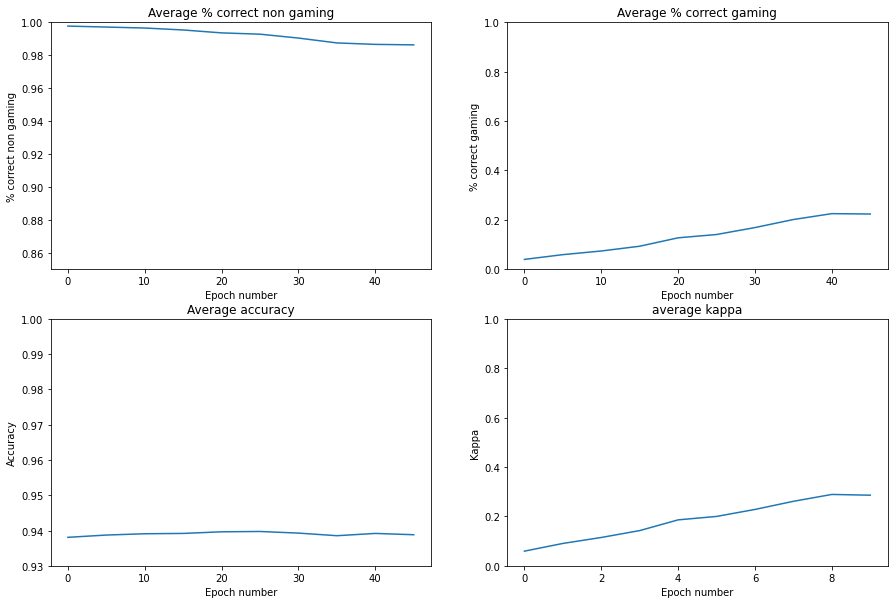

In [16]:

generate_plots(loss_list, kappa_list, count_right_gaming_list, count_right_non_list, count_list)

ave loss: 0.08736653178930283
last reg: -0.03254570811986923
ave total loss: 0.08736653178930283


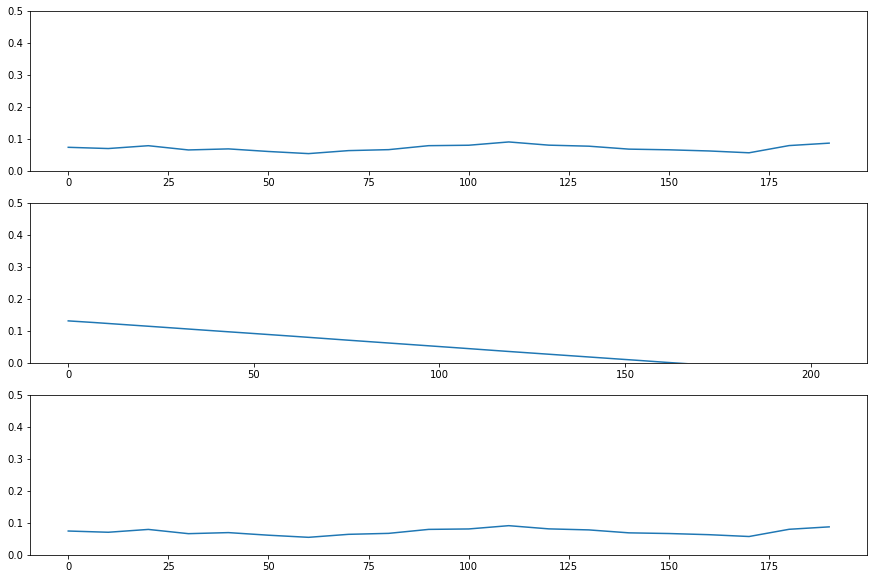

In [8]:
# only run this if you used cond in the training process (or want to look at the loos within the last epoch)

generate_inner_plots(training_loss, training_reg_loss, total_training_loss)
#from epoch 15